# Visualizing Features and Deep Dreaming

Optimizing activations to see what happens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from scipy import ndimage
import PIL

In [3]:
path = untar_data(URLs.PETS);

In [4]:
path_anno = path/'annotations'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)

In [6]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [7]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

In [8]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [13]:
#Train dog/cat breed classifier from lesson 1
learn.fit_one_cycle(4)

Total time: 03:33
epoch  train loss  valid loss  error_rate
1      1.148264    0.328741    0.096474    (00:56)
2      0.490101    0.295689    0.097804    (00:52)
3      0.306131    0.224367    0.067199    (00:52)
4      0.232360    0.212807    0.069195    (00:52)



In [14]:
learn.save('stage-1')

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 02:10
epoch  train loss  valid loss  error_rate
1      0.222477    0.208521    0.065203    (01:05)
2      0.186001    0.204716    0.064538    (01:04)



In [20]:
learn.save('pets_1')

In [9]:
learn.load('pets_1')

One way to approach this would be to run an image through the whole model and grab forward hooks. Since this just looks at activations from one particular layer, I found it simpler to just cut the model to the layer of interest and grab the output.

In [10]:
def trunc_model(model, layer):
    return nn.Sequential(*children(m)[:layer]).cuda()

In [11]:
#Set model to eval
m = learn.model.eval()

In [12]:
m = nn.Sequential(*(children(children(m)[0]) + children(children(m)[1])))

In [13]:
model = trunc_model(m, 6)

# Optimizing Activations

Instead of using images to update weight in a model, we will use the model output to update pixels in the input image. This lets us see the kind of images that really make a particular region of the neural net fire.

In [15]:
def get_static():
    img = np.random.uniform(0, 1, size=(3, 512, 512)).astype(np.float32)
    img = scipy.ndimage.filters.median_filter(img, [8,8,1])
    img = img[None]
    
    return img

In [16]:
def update_img(image, model, iterations, lr, loss_fn, opt=None):

    image = image.clone().detach().requires_grad_(True)
    
    if opt == 'SGD':
        opt = optim.SGD([image], lr)
    elif opt == 'Adam':
        opt = optim.Adam([image], lr, weight_decay=1e-6)
        
    for i in range(iterations):
        if opt is not None:
            opt.zero_grad()
        else:
            model.zero_grad()
        out = model(image)
        loss = loss_fn(out)
        loss.backward()
        
        if opt is not None:
            opt.step()
        else:
            image.data = image.data + lr*image.grad.data
            
    image = imagenet_denorm(image.cpu()).detach()
    image = np.clip(np.rollaxis(to_np(image[0]), 0, 3), 0, 1)
    
    im = PIL.Image.fromarray(np.uint8(image*255))
    
    return im

In [17]:
def optimize_activation(model, iterations, lr, loss_fn, opt=None):
    image = get_static()
    image = torch.from_numpy(image).cuda()
    image = imagenet_norm((image, 0))[0]
    
    return update_img(image, model, iterations, lr, loss_fn, opt=opt)

Different loss functions for optimizing an output layer, channel, neuron or logit. `norm_loss` seems to work the best for the deep dream stuff below.

In [18]:
class activation_losses():
    def __init__(self, idxs):
        self.idxs = idxs
        
    def layer_loss(self, pred):
        return -pred.mean()

    def channel_loss(self, pred):
        a, b = self.idxs
        return -pred[a, b].mean()

    def neuron_loss(self, pred):
        a, b, c, d = self.idxs
        return -pred[a,b,c,d]

    def logit_loss(self, pred):
        a = self.idxs
        return -pred[:,a]
    
    def norm_loss(self, pred):
        return pred.norm()

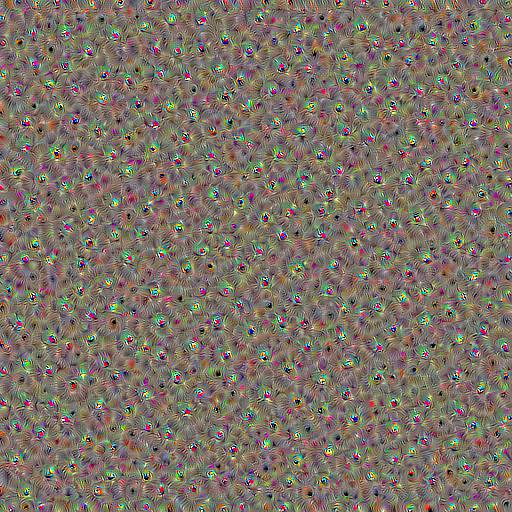

In [19]:
im = optimize_activation(model, 300, 0.3, activation_losses([]).layer_loss, opt='Adam')
im

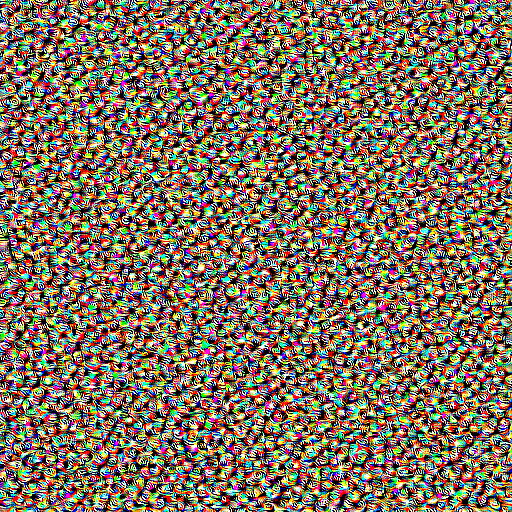

In [21]:
im = optimize_activation(model, 100, 0.3, activation_losses([0, 12]).channel_loss, opt='Adam')
im

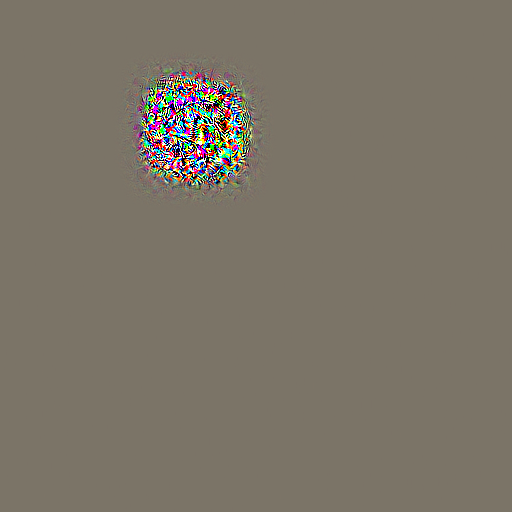

In [23]:
im = optimize_activation(model, 100, 0.3, activation_losses([0, 32, 16, 24]).neuron_loss, opt='Adam')
im

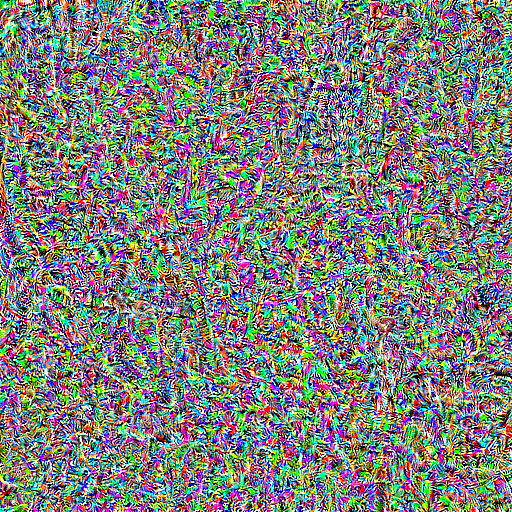

In [24]:
im = optimize_activation(m, 100, 0.3, activation_losses([4]).logit_loss, opt='Adam')
im

# Deep Dream

Deep dream basically performs the above pixel optimizations on different zoomed cuts of an input image, then merges the outputs. Code adapted from [this notebook](https://github.com/sar-gupta/deep-dream-pytorch/blob/master/deep-dream.ipynb)

In [25]:
def dream(image, model, iterations, lr, octave_scale, num_octaves, loss_fn, opt=None):
    
    octaves = [image]
    
    for i in range(num_octaves - 1):
        octaves.append(ndimage.zoom(octaves[-1], (1, 1, 1.0/octave_scale, 1.0/octave_scale), order=1))
        
    octaves = [torch.from_numpy(i).cuda() for i in octaves]
    octaves = [imagenet_norm((i, 0))[0] for i in octaves]
    
    outs = [update_img(i, model, iterations, lr, loss_fn, opt=opt) for i in octaves]
    out_size = outs[0].size
    outs_resized = [outs[0]] + [i.resize(out_size, PIL.Image.ANTIALIAS) for i in outs[1:]]
    
    im_out = PIL.ImageChops.blend(outs_resized[-1], outs_resized[-2], 0.6)
    
    for i in outs_resized[:-2][::-1]:
        im_out = PIL.ImageChops.blend(im_out, i, 0.6)
        
    return im_out

In [26]:
def dream_static(model, iterations, lr, octave_scale, num_octaves, loss_fn, opt=None):
    image = get_static()
    
    return dream(image, model, iterations, lr, octave_scale, num_octaves, loss_fn, opt=opt)

In [27]:
def dream_file(fn, model, iterations, lr, octave_scale, num_octaves, loss_fn, opt=None):
    
    image_pil = PIL.Image.open(fn)
    image = open_image(fn).data.numpy()[None]
    
    im_out = dream(image, model, iterations, lr, octave_scale, num_octaves, loss_fn, opt=opt)
    
    im_out = PIL.ImageChops.blend(im_out, image_pil, 0.6)
        
    return im_out

/home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


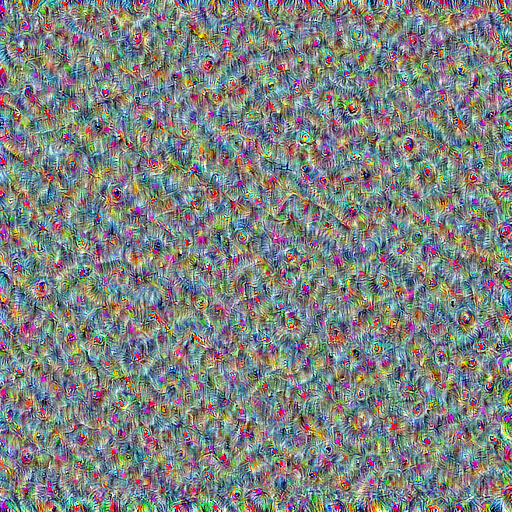

In [28]:
im = dream_static(model, 100, 0.3, 1.4, 6, activation_losses([]).norm_loss)
im

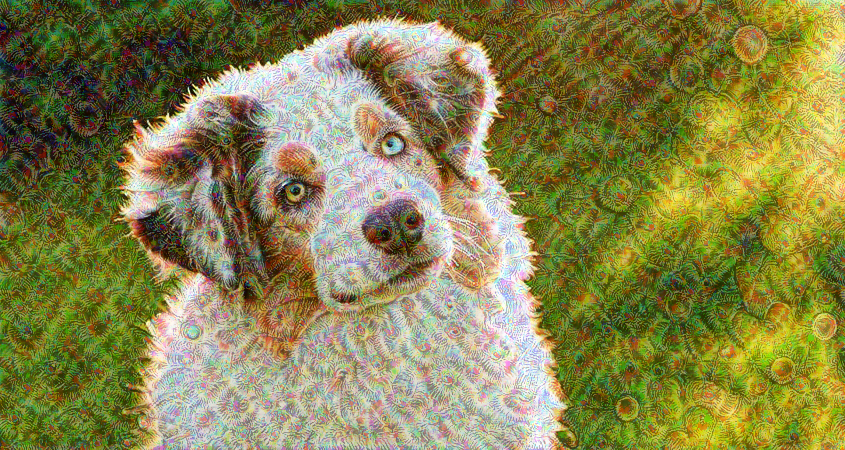

In [29]:
im = dream_file('dog.jpg', model, 300, 0.3, 1.4, 6, activation_losses([]).norm_loss)
im